In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core import KoopDNN,KoopmanNet,KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from dynamics.duffing import dynamics_duff
from dynamics.Vanpol import dynamics_vanpol

from core.adapt_net import AdaptNet


In [2]:
# Base Parameters
dt = 0.01 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 200 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories

## Single System
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

# ## Coupled System
# num_states = 4 # no. of states
# num_inputs = 2 # no. of inputs

In [3]:
# Oscillator parameters
dyn_pars = {}


## Single System

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5

dyn_pars['del_a'] = 0.3
dyn_pars['del_b'] = 0
dyn_pars['del_c'] = 0
dyn_pars['del_d'] = 0

dyn_pars['delay'] =  False

dyn_pars['delay_time'] = 5
dyn_pars['cont_unc_type'] = 'constant'

In [4]:
X_changed, X_unchanged, U = dynamics_duff(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X_changed.shape, U.shape)

(250, 1001, 2) (250, 1000, 1)


In [5]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [6]:
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

l2_diff =  0.07314183189930694


In [7]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  1.5634355794097665


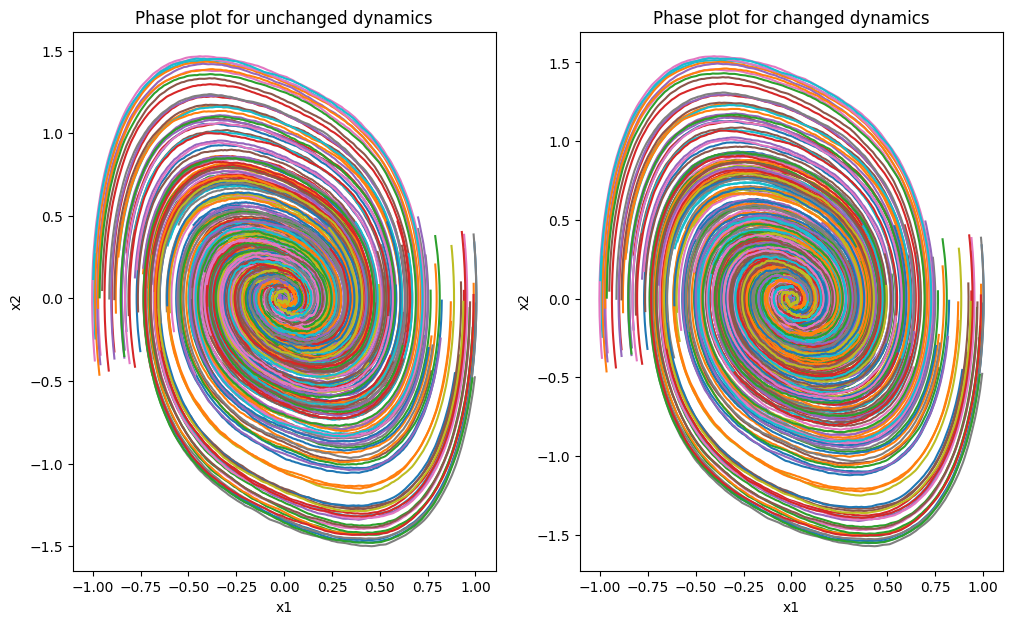

In [8]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])
plt.savefig('phase_plot_duffing.jpg')

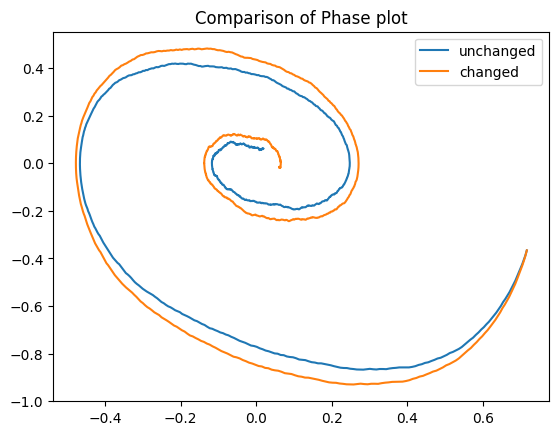

In [9]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.savefig('phase_plot_duffing_single_traj.jpg')
plt.show()


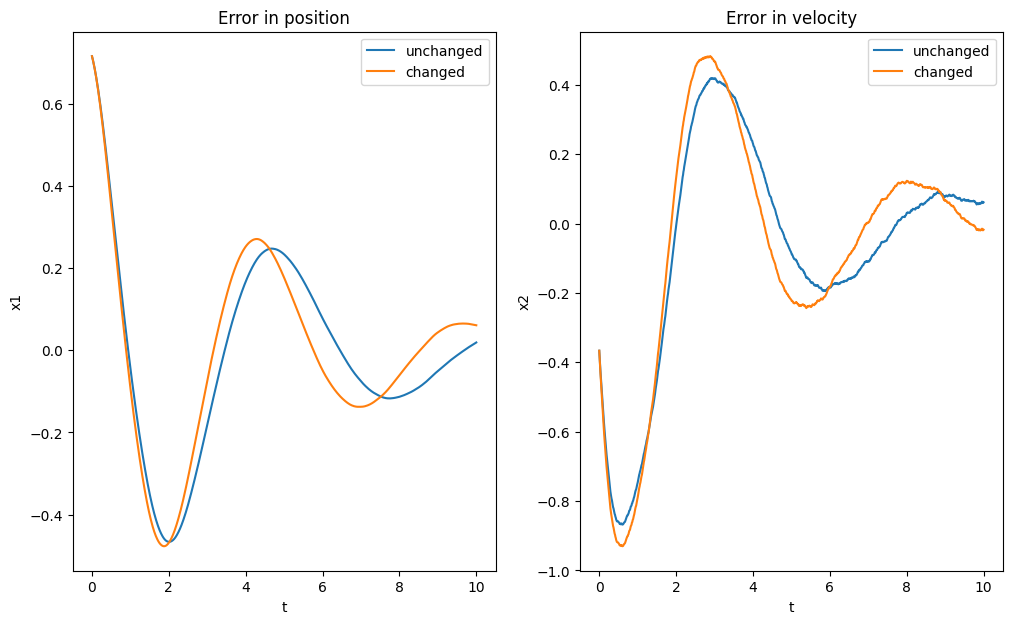

In [10]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_unchanged[4,:,0], label = 'unchanged')
axs[0].plot(T, X_changed[4,:,0], label = 'changed')
axs[0].legend()

axs[1].plot(T, X_unchanged[4,:,1], label = 'unchanged')
axs[1].plot(T, X_changed[4,:,1], label = 'changed')
axs[1].legend()

plt.savefig('vel_pos_err_duffing_single_traj.jpg')

In [11]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

***Koopman bilinear Models***

In [12]:
# auto encoder parameters

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 20
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 2e-4 # 5e-4
net_params['epochs'] = 300
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [13]:
train = False

if train == True:
    file = 'duff_pos_adap.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'duff_pos_adap.pth'
    model_koop_dnn = torch.load(file)

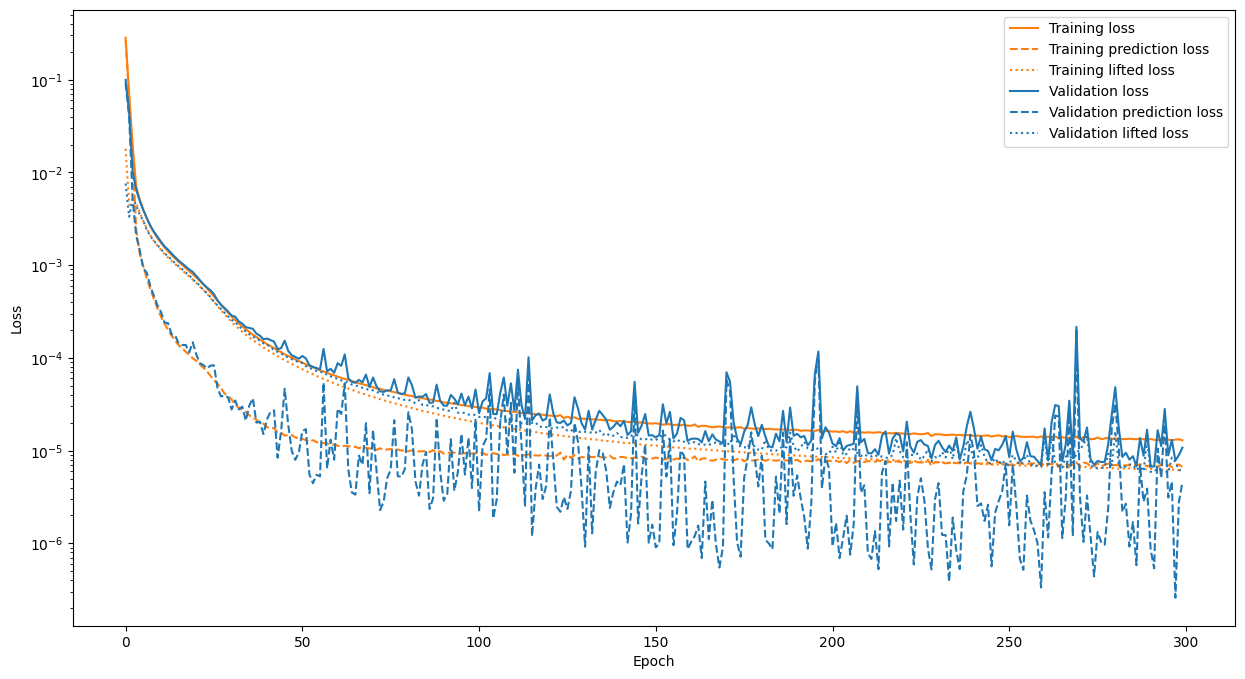

In [14]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Learned Model Parameters

## Bilinear Model Parameters

In [15]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(23, 23) (23, 23) (2, 23)


## Lifting function

# Testing

## Parameters

In [79]:
# test data parameters
num_snaps_test = 5*1000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

## Testing Data

In [80]:
x_changed_test, x_unchanged_test, u_test = dynamics_duff(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
print(model_koop_dnn.test_loss(x_unchanged_test,u_test = u_test))

tensor(2.5300e-05)


In [81]:
x_unchanged_test.shape

(1, 5001, 2)

In [82]:
# Use the preprocessing if available
X_unchanged,_ = model_koop_dnn.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn.net.process(x_changed_test,data_u = u_test)

In [83]:
X_changed.shape

(5000, 5)

In [84]:
# flatten vector
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

x_changed_dot = (x_changed_prime-x_changed)/dt
print(x_changed.shape, u.shape, x_changed_prime.shape)

(5000, 2) (5000, 1) (5000, 2)


# Lifting of states

In [85]:
# initialize states
# initialize the matricies
z_unchanged = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
x_unchanged_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values

In [86]:
# actual lift
z_unchanged[0,:] = lift(x_unchanged[0,:],model_koop_dnn, net_params)
x_unchanged_est[0,:] = x_unchanged[0,:]

# Time Evolution

In [87]:
for i in range(num_snaps_test):
  #bilinear
    z_unchanged[i+1,:] = np.matmul(z_unchanged[i,:],A.T)+np.matmul(np.kron(u[i,:],z_unchanged[i,:]),B.T)
    x_unchanged_est[i+1,:] = np.matmul(z_unchanged[i+1,:],C.T)

# Plotting

## Lifting performance

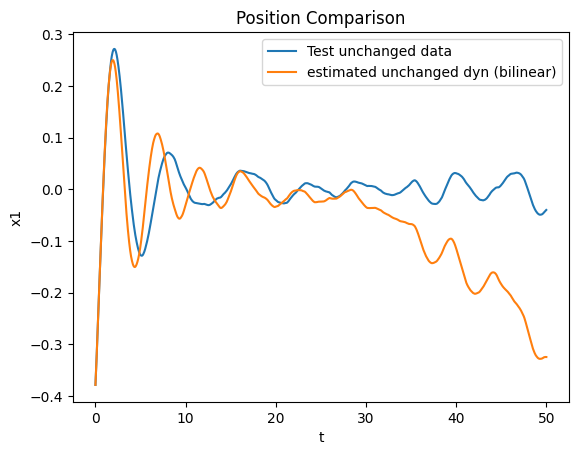

In [88]:
plt.figure()
plt.plot(T_test[:-1], x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test, x_unchanged_est[:,0],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

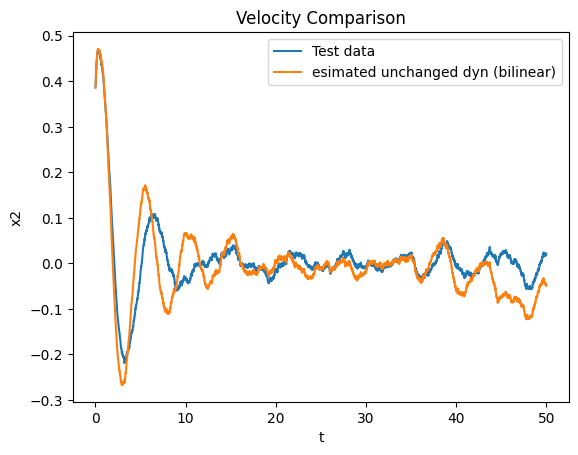

In [89]:
plt.figure()
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

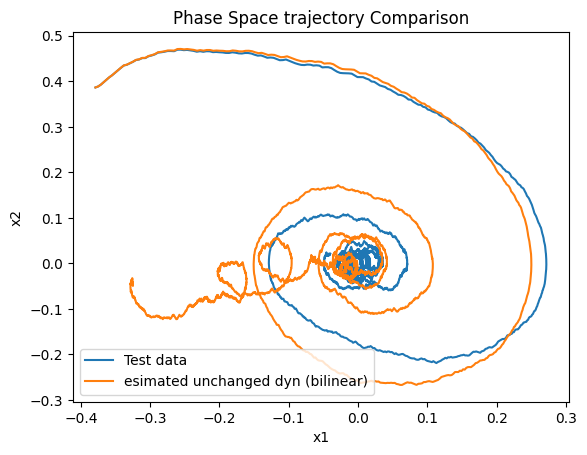

In [90]:
plt.figure()
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

### Error Evolution

In [91]:
error_model = np.linalg.norm((x_unchanged_est[:-1,:]-x_unchanged[:,:]),axis=1)
error_dynamics_no_adapt = np.linalg.norm((x_changed[:,:]-x_unchanged[:,:]),axis=1)

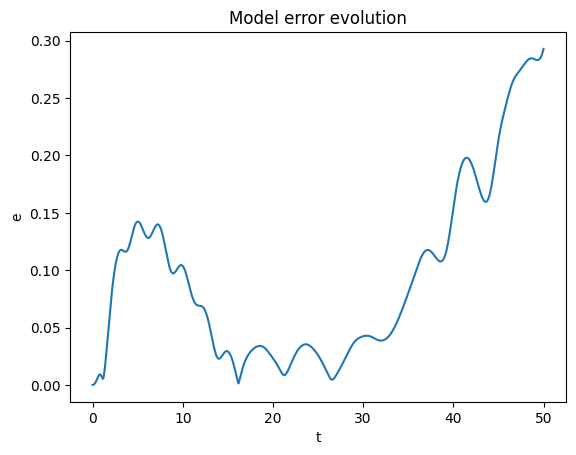

In [92]:
plt.figure()
plt.plot(T_test[:-1],error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

## Deviation from Actual Dynamics

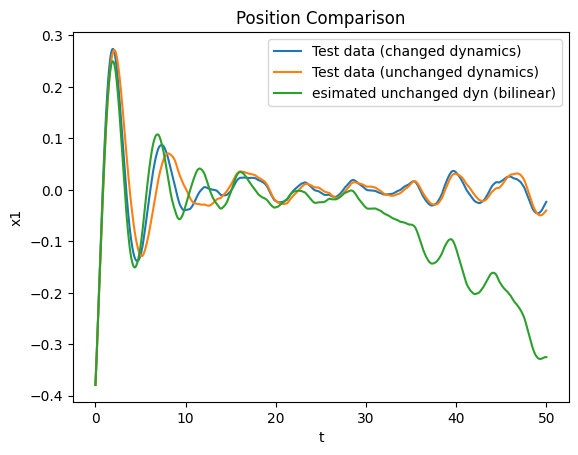

In [93]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,0],label ='Test data (unchanged dynamics)')
plt.plot(T_test,x_unchanged_est[:,0],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

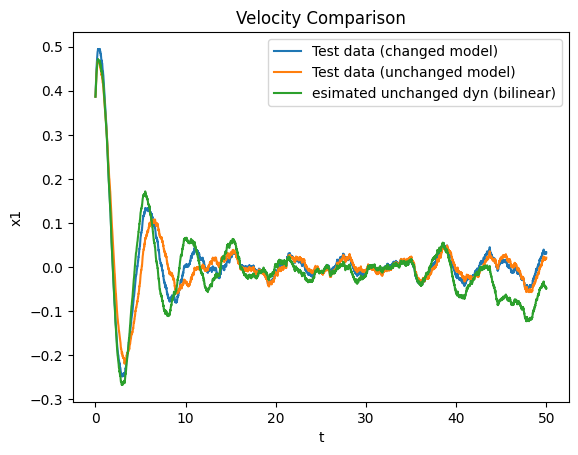

In [94]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data (changed model)')
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data (unchanged model)')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

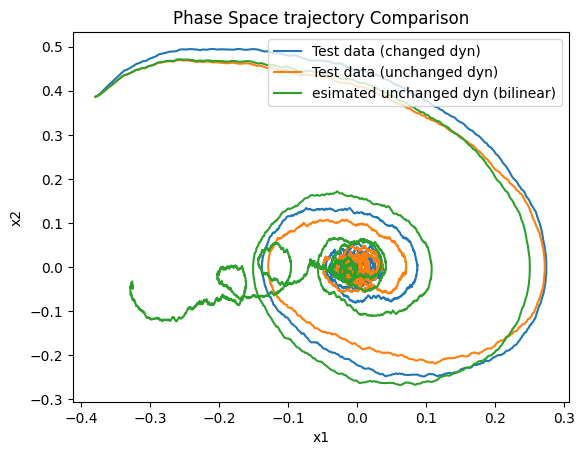

In [95]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data (changed dyn)')
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data (unchanged dyn)')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

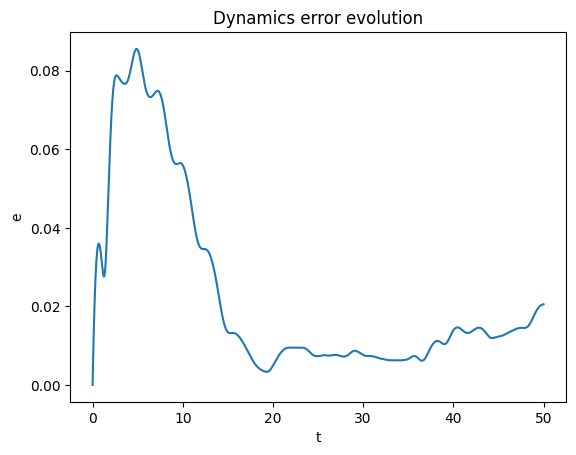

In [96]:
plt.figure()
plt.plot(T_test[:-1],error_dynamics_no_adapt)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')
plt.show()

# Adaptation

## Data Preprocessing

In [97]:
# initialize state matricies
z_adap = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
z_changed = np.empty((n_obs,num_snaps_test)).T #actual lifted state
del_z_prime = np.empty((n_obs,num_snaps_test)).T
zu_unchanged = np.empty((n_obs*num_inputs,num_snaps_test)).T
x_adap_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values
del_A_norm = np.zeros((num_snaps_test,1))
del_B_norm = np.zeros((num_snaps_test,1))
# initialize
z_adap[0,:] = z_unchanged[0,:]
zu_unchanged[0,:] = np.kron(u[0,:],z_unchanged[0,:])
x_adap_est[0,:] = x_unchanged[0,:]

#
adap_window = 2 #hyperparameter

# Adaptive Time evolution

In [98]:
adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = 20
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 2e-4 # 5e-4
adapt_net_params['epochs'] = 5
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 1e-2
adapt_net_params['l1_reg'] = 0
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state
adapt_net_params['warm_start'] = True



del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

adapt_net_params['del_A_prev'] = del_A
adapt_net_params['del_B_prev'] = del_B

switch_time = 30

for i in range(num_snaps_test):
  # incorrect dynamics
    zu_unchanged[i,:] = np.kron(u[i,:],z_adap[i,:])
    # z_unchanged[i+1,:] = np.matmul(z_adap[i,:],A.T + del_A.T)+np.matmul(zu_unchanged[i,:],B.T + del_B.T)
    z_unchanged[i+1,:] = np.matmul(z_adap[i,:],A.T)+np.matmul(zu_unchanged[i,:],B.T)
    
    z_changed[i,:] = lift(x_changed[i,:],model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_changed[i,:] - z_unchanged[i,:]
    if T_test[i] < switch_time:
        if i < adap_window + 1 :
            del_A = np.zeros_like(A)
            del_B = np.zeros_like(B)
        else:
            del_Z_prime = del_z_prime[i-adap_window:i,:].T
            Z_unchanged = z_unchanged[i-(adap_window+1):i-1].T
            ZU_unchanged = zu_unchanged[i-(adap_window+1):i-1].T

            #invoke neural net for adapation
            adapt_network = AdaptNet(adapt_net_params)
            adapt_network.model_pipeline(Z_unchanged, ZU_unchanged, del_Z_prime, print_epoch = True)

            del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)
    
    # if del_B_norm[i] < np.linalg.norm(B):
    #     B_factor = adap_factor
    # else:
    #     B_factor = adap_factor*np.linalg.norm(B)/del_B_norm[i]
    #
    # if del_A_norm[i] < np.linalg.norm(A):
    #     A_factor = adap_factor
    # else:
    #     A_factor = adap_factor*np.linalg.norm(A)/del_A_norm[i]
    #
    # del_A = A_factor*del_A
    # del_B = B_factor*del_B
    adapt_net_params['del_A_prev'] = del_A
    adapt_net_params['del_B_prev'] = del_B
    # adapted model
    z_adap[i+1,:] = np.matmul(z_adap[i,:], A.T+del_A.T) + np.matmul(np.kron(u[i,:],z_adap[i,:]), B + del_B.T )
    x_adap_est[i+1,:] = np.matmul(z_adap[i+1,:],C.T)

In [99]:
A.T.shape, del_A.shape

((23, 23), (23, 23))

# Performance Plotting

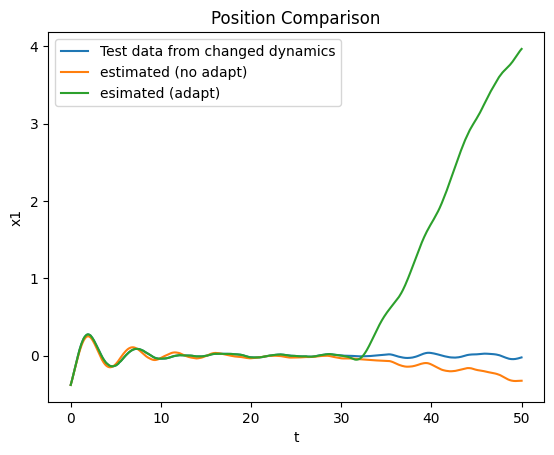

In [100]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data from changed dynamics')
plt.plot(T_test[:],x_unchanged_est[:,0],label ='estimated (no adapt)')
plt.plot(T_test,x_adap_est[:,0],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_pos.jpg')

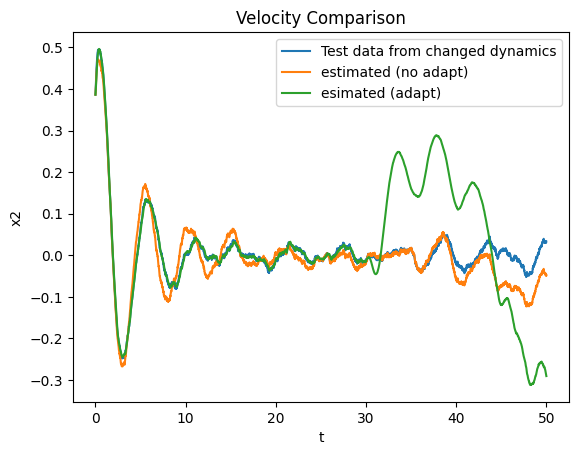

In [101]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data from changed dynamics')
plt.plot(T_test[:],x_unchanged_est[:,1],label ='estimated (no adapt)')
plt.plot(T_test,x_adap_est[:,1],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.savefig('adap_vel.jpg')

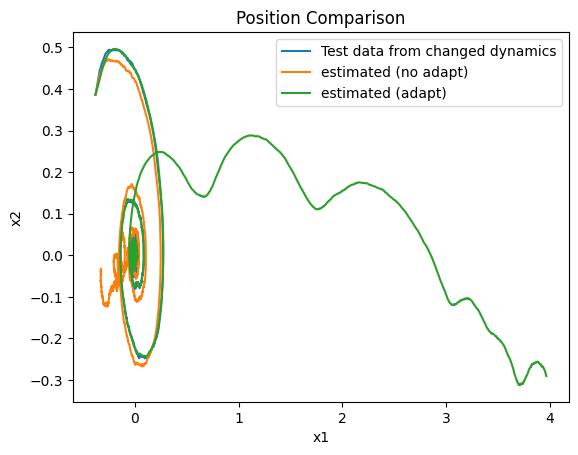

In [102]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data from changed dynamics')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label ='estimated (no adapt)')
plt.plot(x_adap_est[:,0],x_adap_est[:,1],label = 'estimated (adapt)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_phase.jpg')

# Error Comparisons

In [103]:
error_dynamics_adap = np.linalg.norm((x_adap_est[:-1,:]-x_changed[:,:]), axis=1)

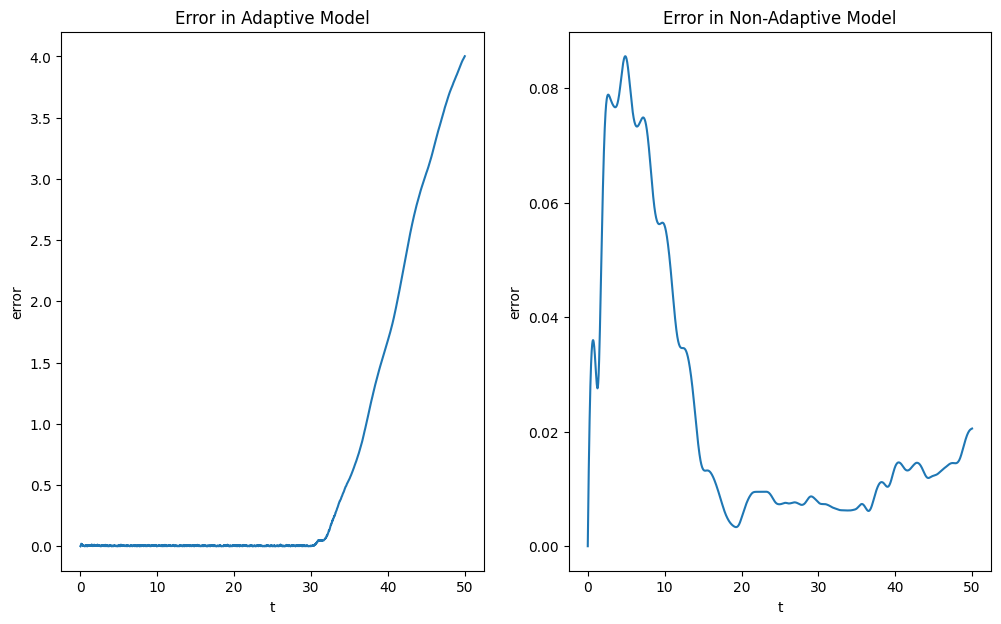

In [104]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in Adaptive Model")
axs[1].set_title("Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')


axs[0].plot(T_test[:-1],error_dynamics_adap)

axs[1].plot(T_test[:-1],error_dynamics_no_adapt)

plt.savefig('adap_error_comp.jpg')

## Norm evolutions

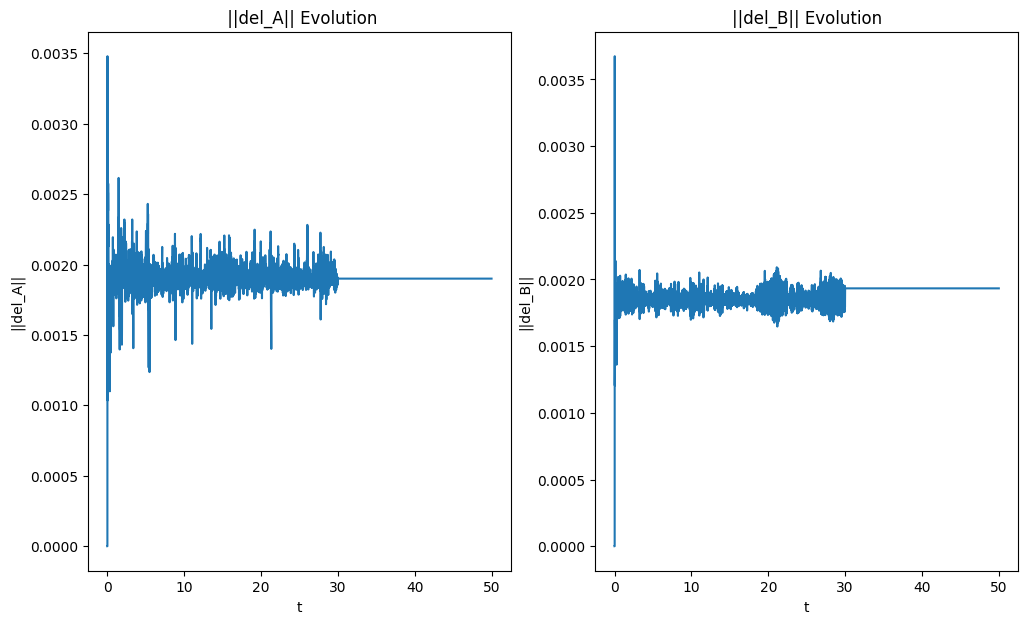

In [105]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(T_test[:-1],del_A_norm)

axs[1].plot(T_test[:-1],del_B_norm)
plt.show()

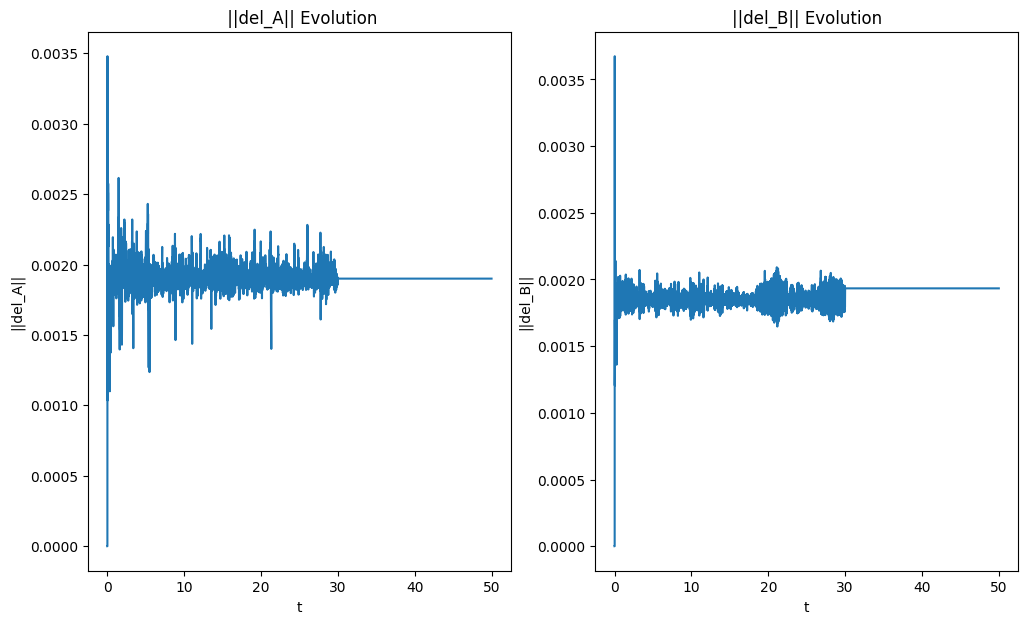

In [106]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(T_test[:-1],del_A_norm)

axs[1].plot(T_test[:-1],del_B_norm)
plt.show()

In [44]:
np.linalg.norm(A)

4.798268

In [45]:
np.linalg.norm(A)

4.798268

In [46]:
np.linalg.norm(B)

0.011357097

In [47]:
np.linalg.norm(B)

0.011357097

## Post Adaptive Learning

In [48]:
z_post_adap = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
x_post_adap_est = np.zeros((num_states,num_snaps_test+1)).T 
x_post_adap_est[0,:] = x_unchanged[0,:]
z_post_adap[0,:] = z_unchanged[0,:]

In [49]:
for i in range(num_snaps_test):
    z_post_adap[i+1,:] = np.matmul(z_post_adap[i,:], A.T+del_A.T) + np.matmul(np.kron(u[i,:],z_post_adap[i,:]), B + del_B.T )
    x_post_adap_est[i+1,:] = np.matmul(z_post_adap[i+1,:],C.T)

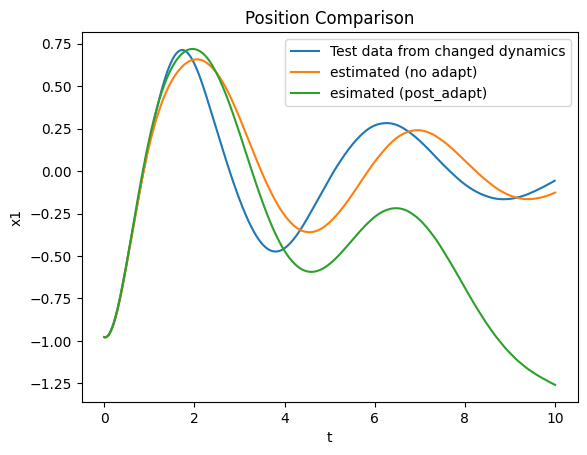

In [50]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data from changed dynamics')
plt.plot(T_test[:],x_unchanged_est[:,0],label ='estimated (no adapt)')
plt.plot(T_test,x_post_adap_est[:,0],label = 'esimated (post_adapt)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_pos.jpg')

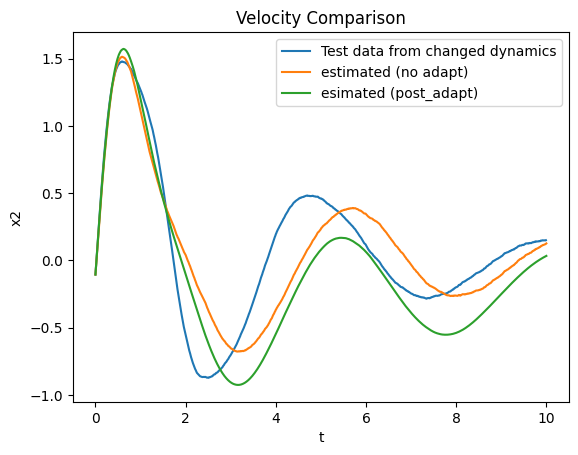

In [51]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data from changed dynamics')
plt.plot(T_test[:],x_unchanged_est[:,1],label ='estimated (no adapt)')
plt.plot(T_test,x_post_adap_est[:,1],label = 'esimated (post_adapt)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.savefig('adap_vel.jpg')

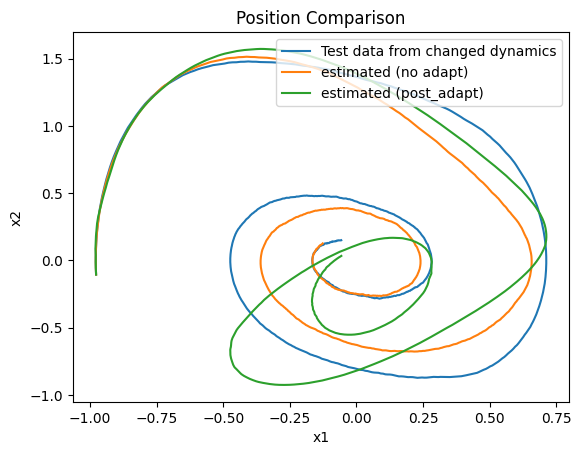

In [52]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data from changed dynamics')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label ='estimated (no adapt)')
plt.plot(x_adap_est[:,0],x_post_adap_est[:,1],label = 'estimated (post_adapt)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_phase.jpg')